Collaborative Filtering: Collaborative filtering is to discover the similarities on the user’s past behavior and make predictions to the user based on a similar preferecne with other users. This model is then used to predict items (or ratings for items) that the user may have an interest in.
Content-Based Filtering: Content-Based Filtering is used to produce items recommendation based on items’ characteristics.


In [24]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns



In [25]:
# Load product info
product_info = pd.read_csv('../data/raw/archive/product_info.csv')
product_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          8494 non-null   object 
 1   product_name        8494 non-null   object 
 2   brand_id            8494 non-null   int64  
 3   brand_name          8494 non-null   object 
 4   loves_count         8494 non-null   int64  
 5   rating              8216 non-null   float64
 6   reviews             8216 non-null   float64
 7   size                6863 non-null   object 
 8   variation_type      7050 non-null   object 
 9   variation_value     6896 non-null   object 
 10  variation_desc      1250 non-null   object 
 11  ingredients         7549 non-null   object 
 12  price_usd           8494 non-null   float64
 13  value_price_usd     451 non-null    float64
 14  sale_price_usd      270 non-null    float64
 15  limited_edition     8494 non-null   int64  
 16  new   

In [26]:
reviews250 = pd.read_csv('../data/raw/archive/reviews_0_250.csv', low_memory=False, index_col=0)
reviews500 = pd.read_csv('../data/raw/archive/reviews_250_500.csv', low_memory=False, index_col=0)
reviews750 = pd.read_csv('../data/raw/archive/reviews_500_750.csv', low_memory=False, index_col=0)
reviews1000 = pd.read_csv('../data/raw/archive/reviews_750_1000.csv', low_memory=False, index_col=0)
reviews1500 = pd.read_csv('../data/raw/archive/reviews_1000_1500.csv', low_memory=False, index_col=0)
reviewsend = pd.read_csv('../data/raw/archive/reviews_1500_end.csv', low_memory=False, index_col=0)

In [50]:
df = pd.concat([reviews250, reviews500, reviews750, reviews1000, reviews1500, reviewsend])


In [51]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1301136 entries, 0 to 49976
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   author_id                 1301136 non-null  object 
 1   rating                    1301136 non-null  int64  
 2   is_recommended            1107162 non-null  float64
 3   helpfulness               631670 non-null   float64
 4   total_feedback_count      1301136 non-null  int64  
 5   total_neg_feedback_count  1301136 non-null  int64  
 6   total_pos_feedback_count  1301136 non-null  int64  
 7   submission_time           1301136 non-null  object 
 8   review_text               1299520 non-null  object 
 9   review_title              930754 non-null   object 
 10  skin_tone                 1103798 non-null  object 
 11  eye_color                 1057734 non-null  object 
 12  skin_type                 1172830 non-null  object 
 13  hair_color                1037824 

In [52]:
df.rename(columns={'author_id': 'user', 'product_id':'item'}, inplace=True)
df = df[['user','item','rating', 'skin_tone', 'eye_color', 'skin_type', 'hair_color']]

In [53]:
# making new data frame with dropped NA values 
print(df.shape)
df = df.dropna(axis = 0, how ='any')    
print(df.shape)

(1301136, 7)
(1010828, 7)


In [55]:
data1 =df[['user','item','rating']]

In [38]:
from surprise import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

In [56]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1010828 entries, 2 to 49974
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   user    1010828 non-null  object
 1   item    1010828 non-null  object
 2   rating  1010828 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 30.8+ MB


In [57]:
# Assume you have a pandas DataFrame df with columns 'user', 'item', 'rating'
reader = Reader(rating_scale=(1, 5))  # Here, we assume the ratings are on a scale of 1 to 5.
data = Dataset.load_from_df(data1, reader)



In [58]:
# Split data into train and test
trainset, testset = train_test_split(data, test_size=0.25)



In [59]:
# Instantiate SVD and fit the trainset
algo = SVD()
algo.fit(trainset)



In [61]:
# Predictions can now be made with the predict() method
# For example, predicting the rating of the item with id 'item_id' for the user with id 'user_id'
user_id = '6538326896'
item_id = 'P480354'
prediction = algo.predict(user_id, item_id)
print(prediction.est)

3.8870061706662136


## Using predictions

In [29]:
user_ids = df.user[0:100]
item_ids =df.item[240000:240100]
# Assume user_ids and item_ids are arrays or lists of user ids and item ids.
#user_ids = ['7446977307', '1991973234', '42434587408']
#item_ids = ['P467602', 'P481993', 'P481993']

# Assuming 'algo' is your trained model
predictions = [algo.predict(user_id, item_id) for user_id, item_id in zip(user_ids, item_ids)]

# Extract the estimated ratings
estimated_ratings = [pred.est for pred in predictions]

[4.396479652335173, 4.5000100879965474, 4.403177401203394, 4.364065229910177, 4.181701566746589, 4.387133216525899, 4.527875255609867, 4.090233541220962, 4.195787222993954, 4.389650517678031, 4.408925500260975, 4.688387881922074, 4.364065229910177, 4.221840336423887, 4.364065229910177, 4.626435010840074, 4.406021462965932, 4.097555472862863, 4.626005277772955, 4.057451626677103, 4.513620857359802, 4.614567952560199, 4.147690178529307, 3.8521312078649097, 4.46595316917864, 4.629615195455936, 3.9935201083425267, 3.838939246424404, 4.899294568789001, 4.541559095838191, 4.4454739166493225, 4.3424149759126225, 4.2664101118053095, 4.364065229910177, 4.20563570196139, 4.108267413880228, 4.837437500483864, 3.7908910327062015, 4.450979821455691, 4.273410465807041, 4.5530370412688645, 4.364065229910177, 3.985467574800956, 4.370352807868894, 4.314382237674071, 4.2792569401633855, 4.492426999538507, 4.3857859233084335, 4.67516577411454, 4.364065229910177, 3.936017741042826, 3.849350007615776, 4.01

### Cross-validation

In [85]:
# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1007  1.0940  1.0990  1.0866  1.0962  1.0953  0.0049  
MAE (testset)     0.8279  0.8217  0.8261  0.8177  0.8227  0.8232  0.0036  
Fit time          2.50    2.54    2.59    2.60    2.67    2.58    0.06    
Test time         0.47    0.29    0.29    0.64    0.52    0.44    0.14    


{'test_rmse': array([1.10073787, 1.0939508 , 1.09900359, 1.08655776, 1.09622941]),
 'test_mae': array([0.8278647 , 0.82174141, 0.82610578, 0.81768021, 0.82273007]),
 'fit_time': (2.4970932006835938,
  2.537647008895874,
  2.586132049560547,
  2.5957629680633545,
  2.6729037761688232),
 'test_time': (0.4716978073120117,
  0.29118895530700684,
  0.2869832515716553,
  0.6413369178771973,
  0.5224218368530273)}

In [86]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split

# Assuming you have a pandas DataFrame df with columns 'user', 'item', 'rating'
reader = Reader(rating_scale=(1, 5))  # Here, we assume the ratings are on a scale of 1 to 5.
data = Dataset.load_from_df(df[['user', 'item', 'rating']], reader)

# Split data into train and test
trainset, testset = train_test_split(data, test_size=0.25)

# Use the SVD algorithm
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE and MAE
accuracy.rmse(predictions)
accuracy.mae(predictions)

# For precision and recall we need to define a threshold for positive vs. negative ratings
# Here we'll use 3.5 (on a 5-point scale), but this will depend on how your ratings are distributed
threshold = 3.5
true_positives = sum([1 for prediction in predictions if prediction.r_ui >= threshold and prediction.est >= threshold])
true_negatives = sum([1 for prediction in predictions if prediction.r_ui < threshold and prediction.est < threshold])
false_positives = sum([1 for prediction in predictions if prediction.r_ui < threshold and prediction.est >= threshold])
false_negatives = sum([1 for prediction in predictions if prediction.r_ui >= threshold and prediction.est < threshold])

# Compute precision, recall, and F1 score
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")


RMSE: 1.1136
MAE:  0.8425
Precision: 0.82
Recall: 0.96
F1: 0.89


In [87]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

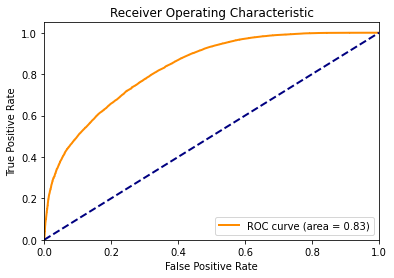

In [88]:
# Binarize the ratings in testset
testset_binarized = [1 if rating >= 4 else 0 for (_, _, rating) in testset]

# Predict ratings for the testset
preds = [pred.est for pred in predictions]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(testset_binarized, preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Hyperparameter tuning

In [90]:
# Define the parameter grid
param_grid = {
    'n_epochs': [5, 10, 20], 
    'lr_all': [0.002, 0.005, 0.01], 
    'reg_all': [0.2, 0.4, 0.6]
}

algo = SVD
# Run a grid search with cross validation
gs = GridSearchCV(algo, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# Print the best score and the best parameters
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.200677801186598
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


#### Evaluate the model: 
Use different evaluation metrics to understand how well your model is performing. Common metrics for recommender systems include Root Mean Square Error (RMSE), Mean Absolute Error (MAE), precision, recall, F1 score, and Area Under the ROC Curve (AUC-ROC).
#### Hyperparameter tuning: 
The SVD algorithm has several hyperparameters that can significantly impact its performance. You can use techniques like grid search or random search to find the optimal values for these parameters.
#### Cross-validation:
Implement cross-validation to get a more robust estimate of your model's performance. This involves splitting your data into multiple folds and training and testing your model on different combinations of these folds.
#### Try different algorithms:
While SVD is a powerful algorithm, there are many other algorithms for recommendation, including other matrix factorization methods (e.g., Non-negative Matrix Factorization), neighborhood-based methods, and deep learning methods. Different algorithms might work better for different types of data and different problem settings.
#### Incorporate additional data:
If you have additional data available (e.g., user demographic information, item features), you might consider using a hybrid recommendation approach that combines collaborative filtering with content-based filtering.
#### Test the system with real users:
Ultimately, the best way to evaluate a recommender system is to see how it performs with real users. Consider implementing an A/B test to compare your recommender system with a baseline or previous version.
#### Optimize for scalability and efficiency: 
If your system works well on a small scale, consider how to optimize it to handle larger datasets and provide recommendations more quickly. This might involve improving your data processing code, parallelizing the computation, or moving to a distributed computing environment.
#### Continuous learning:
If new data comes in regularly (e.g., new user ratings), consider how to update your model over time. This could involve re-training the model from scratch periodically or using an online learning approach that updates the model incrementally.








### Note on the K-Nearest Neighbors methods
(KNN) algorithm is a simple and commonly used method for making recommendations, but it can struggle with large datasets due to its computational complexity.

KNN works by computing distances between items or users, which requires comparing each item (or user) to every other item (or user). As a result, the time and space complexity of the algorithm is quadratic in the number of items or users. This means that as the dataset grows, the time and memory required to run KNN increase rapidly.

For a dataset with 350,000+ ratings, depending on the number of unique users and items, KNN might still be feasible, but it could be slow and require a large amount of memory. If your dataset is large and you're finding that KNN is too slow or requires too much memory, you might consider using a more scalable algorithm.

Matrix factorization methods, such as SVD (Singular Value Decomposition) or NMF (Non-negative Matrix Factorization), are often a good choice for larger datasets. These methods are more computationally efficient than KNN, and they can also handle sparsity in the ratings matrix more effectively. They work by learning latent factors for each user and item, which capture the underlying patterns in the ratings and can be used to predict missing ratings.

Another approach for large datasets is to use deep learning methods, which can model complex non-linear relationships and automatically learn useful features from the data. However, these methods can be more complex to implement and interpret, and they may require more computational resources and longer training times.

In this code, we are using the default hyperparameters for the NMF algorithm, which are:

n_factors: The number of factors. Default is 15.
n_epochs: The number of iteration of the SGD procedure. Default is 50.
biased: Whether to use baselines (or biases). Default is True.

In [10]:
from surprise import NMF, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# Assuming you have a pandas DataFrame df with columns 'user', 'item', 'rating'
#reader = Reader(rating_scale=(1, 5))  # Here, we assume the ratings are on a scale of 1 to 5.
#data = Dataset.load_from_df(df[['user', 'item', 'rating']], reader)

# Split data into train and test
trainset, testset = train_test_split(data, test_size=0.25)

# Use the NMF algorithm
algo = NMF()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
print("RMSE: ", accuracy.rmse(predictions))

# compute MAE
print("MAE: ", accuracy.mae(predictions))


RMSE: 1.1729
RMSE:  1.172942798785202
MAE:  0.8180
MAE:  0.8179957113033712


In [11]:
# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1586  1.1600  1.1625  1.1561  1.1538  1.1582  0.0030  
MAE (testset)     0.8008  0.7994  0.8075  0.7968  0.7919  0.7993  0.0051  
Fit time          9.49    9.65    9.78    9.81    10.13   9.77    0.21    
Test time         0.25    0.24    0.70    0.54    0.26    0.40    0.19    


{'test_rmse': array([1.15856256, 1.1599702 , 1.16251299, 1.15612594, 1.15381676]),
 'test_mae': array([0.80077001, 0.79943531, 0.80750007, 0.79684666, 0.79191065]),
 'fit_time': (9.489989042282104,
  9.64850115776062,
  9.780000925064087,
  9.805248022079468,
  10.128991842269897),
 'test_time': (0.25104308128356934,
  0.24487018585205078,
  0.7042412757873535,
  0.5388972759246826,
  0.2569730281829834)}

Well it looks like the Mean RMSE is 1.15 and MAE is 0.79 while SVD had 1.09, 0.82 RMSE and MAE correspondingly. 
I prefer SVD due to its smaller EMSE, which means it makes less large errors and I want to be conservative and prefer to give slightly wrong compared to fe very wrong recommendations.

## Biased SVD

In [12]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

# Assuming you have a pandas DataFrame df with columns 'user', 'item', 'rating'
reader = Reader(rating_scale=(1, 5))  # Here, we assume the ratings are on a scale of 1 to 5.
data = Dataset.load_from_df(df[['user', 'item', 'rating']], reader)

# Use the biased SVD algorithm
algo = SVD(biased=True) # default is True

# Perform 5-fold cross-validation
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# The cross_validate function returns a dict containing measures of accuracy for each fold
# You can print these out as follows:
for i in range(5):
    print(f"Fold {i+1}")
    print(f"RMSE: {results['test_rmse'][i]:.2f}")
    print(f"MAE: {results['test_mae'][i]:.2f}")
    print()


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0918  1.0937  1.0918  1.0945  1.0974  1.0938  0.0021  
MAE (testset)     0.8222  0.8211  0.8205  0.8232  0.8251  0.8224  0.0016  
Fit time          2.53    2.61    2.67    2.71    2.63    2.63    0.06    
Test time         0.28    0.28    0.29    0.71    0.27    0.37    0.17    
Fold 1
RMSE: 1.09
MAE: 0.82

Fold 2
RMSE: 1.09
MAE: 0.82

Fold 3
RMSE: 1.09
MAE: 0.82

Fold 4
RMSE: 1.09
MAE: 0.82

Fold 5
RMSE: 1.10
MAE: 0.83



Well, it looks like Biased SVD doesn't perform much better, so we prefer the parsimonious model: Regular SVD.

## Light FM

LightFM is a hybrid matrix factorization model that represents users and items as linear combinations of their content features' latent factors. In other words, it is capable of using both collaborative and content-based information for recommendations, which makes it a good choice for dealing with both cold start and sparsity problems. 

The inputs to the LightFM model can be divided into two categories:

#### Collaborative Input: 
This is the user-item interaction matrix. It's a binary matrix where each row represents a user, each column represents an item, and each cell represents the interaction between the user and the item. This can be expressed as explicit feedback (e.g., ratings) or implicit feedback (e.g., views, clicks).
#### Content-Based Input: 
These are the user and item features. They are also represented as binary matrices:
#### User features: 
Each row represents a user, and each column represents a user feature.
#### Item features: 
Each row represents an item, and each column represents an item feature.
Note that if you don't provide user and/or item features, LightFM uses their identities as features, which makes it equivalent to Matrix Factorization or collaborative filtering.

Here is an example of how to create a LightFM model:

In [9]:
from lightfm import LightFM
from lightfm.data import Dataset



In [10]:
product_info.variation_type.unique()

array([nan, 'Size + Concentration + Formulation', 'Scent', 'Size',
       'Color', 'Size + Concentration', 'Type', 'Formulation'],
      dtype=object)

In [11]:
product_info2 = product_info.rename(columns={'product_id': 'item_id'})
product_info3 = product_info2[['item_id','limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'primary_category', 'child_count']]

product_info3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   item_id            8494 non-null   object
 1   limited_edition    8494 non-null   int64 
 2   new                8494 non-null   int64 
 3   online_only        8494 non-null   int64 
 4   out_of_stock       8494 non-null   int64 
 5   sephora_exclusive  8494 non-null   int64 
 6   primary_category   8494 non-null   object
 7   child_count        8494 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 531.0+ KB


In [12]:
interactions_df = df.rename(columns={'user': 'user_id', 'item':'item_id'})
interactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350638 entries, 5 to 49943
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   user_id                   350638 non-null  object 
 1   rating                    350638 non-null  int64  
 2   is_recommended            350638 non-null  float64
 3   helpfulness               350638 non-null  float64
 4   total_feedback_count      350638 non-null  int64  
 5   total_neg_feedback_count  350638 non-null  int64  
 6   total_pos_feedback_count  350638 non-null  int64  
 7   submission_time           350638 non-null  object 
 8   review_text               350638 non-null  object 
 9   review_title              350638 non-null  object 
 10  skin_tone                 350638 non-null  object 
 11  eye_color                 350638 non-null  object 
 12  skin_type                 350638 non-null  object 
 13  hair_color                350638 non-null  object 

In [13]:
item_features_df = product_info3[['item_id', 'limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'primary_category', 'child_count']]
user_features_df = interactions_df[['user_id','item_id', 'skin_tone', 'eye_color', 'skin_type', 'hair_color']]


In [14]:
# Assuming item_ids in your interactions data is a list of item ids in the interaction data
interaction_item_ids = set(interactions_df['item_id'])
# Filter item features data
filtered_item_features_df = item_features_df[item_features_df['item_id'].isin(interaction_item_ids)]



In [16]:
items_features = [(row[0], list(row[1:])) for row in filtered_item_features_df.values]
print(items_features)


[('P439055', [0, 0, 0, 0, 1, 'Skincare', 0]), ('P421277', [0, 0, 0, 0, 1, 'Skincare', 1]), ('P467602', [0, 0, 0, 0, 1, 'Skincare', 0]), ('P432045', [0, 0, 0, 0, 1, 'Skincare', 0]), ('P311143', [0, 0, 0, 0, 0, 'Skincare', 0]), ('P384537', [0, 0, 0, 0, 0, 'Skincare', 1]), ('P388200', [0, 0, 0, 1, 0, 'Skincare', 0]), ('P296413', [0, 0, 0, 0, 0, 'Skincare', 0]), ('P500716', [0, 0, 0, 0, 1, 'Skincare', 0]), ('P379907', [0, 0, 0, 0, 0, 'Skincare', 0]), ('P296415', [0, 0, 0, 0, 0, 'Skincare', 0]), ('P392945', [0, 0, 0, 0, 0, 'Skincare', 0]), ('P282935', [0, 0, 0, 1, 0, 'Skincare', 0]), ('P474809', [0, 0, 0, 0, 1, 'Skincare', 0]), ('P416552', [0, 0, 0, 0, 1, 'Skincare', 0]), ('P471000', [0, 0, 0, 0, 1, 'Skincare', 0]), ('P480274', [0, 0, 0, 0, 1, 'Skincare', 0]), ('P453818', [0, 0, 0, 0, 1, 'Skincare', 0]), ('P442859', [0, 0, 0, 0, 1, 'Skincare', 0]), ('P388262', [0, 0, 0, 0, 0, 'Skincare', 0]), ('P457694', [0, 0, 0, 0, 1, 'Skincare', 0]), ('P447504', [0, 0, 0, 0, 1, 'Skincare', 0]), ('P404169

In [17]:
users_features =  [(row[0], list(row[1:])) for row in user_features_df.values]
#print(users_features)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
# Assuming we have interaction data and item and user features
# interactions_df: user_id, item_id
# item_features_df: item_id, feature_1, feature_2, ...
# user_features_df: user_id, feature_1, feature_2, ...

# Create a LightFM dataset
dataset = Dataset()
dataset.fit(
   users=interactions_df['user_id'],
   items=interactions_df['item_id'],
   item_features=['limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'primary_category', 'child_count'],
   user_features=['skin_tone', 'eye_color', 'skin_type', 'hair_color']
)

In [20]:
# Building the interactions matrix
(interactions, weights) = dataset.build_interactions((row['user_id'], row['item_id']) for index, row in interactions_df.iterrows())

In [23]:
user_features_list = dataset.build_user_features(users_features)
item_features_list = dataset.build_item_features(items_features)

ValueError: Feature P420652 not in feature mapping. Call fit first.

In [22]:
# Train the model
model = LightFM()
model.fit(interactions, user_features=users_features, item_features=items_features, epochs=10)

AttributeError: 'list' object has no attribute 'tocsr'